In [1]:
from mlgrad.risk import ERisk, ERiskGB
from mlgrad.loss import SquareErrorLoss, ErrorLoss
from mlgrad.model import LinearFuncModel, SigmaNeuronModel, FFNetworkModel, \
                        FFNetworkFuncModel, SigmaNeuronModelLayer, LinearModel
from mlgrad.func import SoftPlus, Sqrt, Sigmoidal, HingeSqrt, Arctang, Absolute

from mlgrad import erm_fg, erm_irgd, fg, erm_fg, erisk
from mlgrad.regr import m_regression_irls
from mlgrad.af import averaging_function
from mlgrad.weights import MWeights

import numpy as np

In [2]:
import sklearn.datasets as datasets
import sklearn.metrics as metrics
import sklearn.preprocessing as preprocessing
import matplotlib.pyplot as plt

from random import random

import sys
print(sys.version)

3.11.2 (main, Mar 13 2023, 12:18:29) [GCC 12.2.0]


In [3]:
lfm = LinearFuncModel()
for k in range(100):
    mod = SigmaNeuronModel(Sigmoidal(), 2)
    mod.init_param()
    a = 8*random()-4
    lfm.add(mod, a)

In [4]:
N = 1000
M = 100
X = 6*np.random.random((N, 2))-3
Y = np.array([lfm(Xk) for Xk in X])
print(X.shape, Y.shape)
print(X.dtype, Y.dtype)

Is = np.random.randint(0, N, M)
Y_o = Y.copy()
for k in Is:
    Y_o[k] = 10 * Y[k]
X_o = X.copy()

(1000, 2) (1000,)
float64 float64


In [5]:
from mlgrad.boost.gb_regression import gb_fit, gb_fit_agg

In [6]:
def new_model(n):
    mod = SigmaNeuronModel(Sigmoidal(), n)
    mod.init_param()
    return mod

m = 200

gb0 = gb_fit(X, Y, new_model, h=0.01, tol=1.0e-6, n_iter=m)
lfm0, lvals0 = gb0.complex_model, gb0.lvals

In [7]:
gb = gb_fit(X_o, Y_o, new_model, h=0.01, tol=1.0e-6, n_iter=m)
lfm, lvals = gb.complex_model, gb.lvals

In [8]:
alpha=0.9
gb_agg = gb_fit_agg(X_o, Y_o, new_model, alpha=alpha, h=0.01, tol=1.0e-6, n_iter=m, n_iter2=22)
lfm_agg, lvals_agg = gb_agg.complex_model, gb_agg.lvals

In [9]:
# print(np.asarray(lfm.weights))
# print(np.asarray(lfm_agg.weights))

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


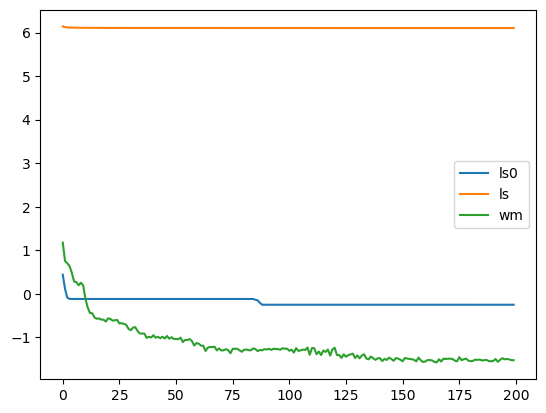

In [10]:
plt.plot(np.log(lvals0), label='ls0')
plt.plot(np.log(lvals), label='ls')
plt.plot(np.log(lvals_agg), label='wm')
plt.legend()
plt.savefig('boosting_nn_%.0f_lvals.eps' % (alpha*100,))
plt.show()

In [11]:
Y_ls0 = lfm0.evaluate_all(X)
Y_ls = lfm.evaluate_all(X)
Y_agg = lfm_agg.evaluate_all(X)

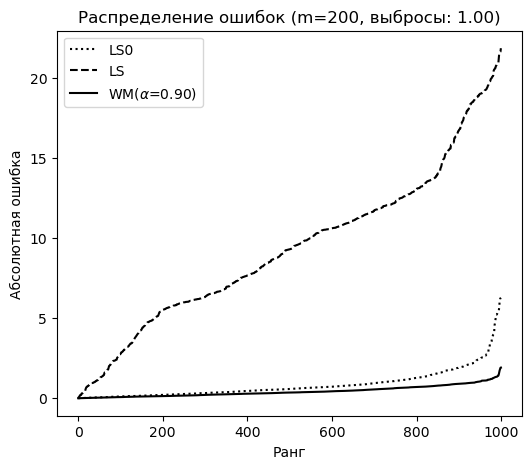

In [12]:
plt.figure(figsize=(6,5))
plt.xlabel('Ранг')
plt.ylabel('Абсолютная ошибка')
plt.title("Распределение ошибок (m=%s, выбросы: %.2f)" % (m, M/100))
plt.plot(sorted(np.abs(Y_ls0-Y)), linestyle=':', color='k', label='LS0') #, marker='o', markersize=1)
plt.plot(sorted(np.abs(Y_ls-Y)), linestyle='--', color='k', label='LS') #, marker='o', markersize=1)
plt.plot(sorted(np.abs(Y_agg-Y)), linestyle='-', color='k', label="WM($\\alpha$=%.2f)" % alpha) #, marker='o', markersize=1)
plt.savefig('boosting_nn_%.0f_%s_%s_errors.eps' % (alpha*100,m,M))
plt.legend()
plt.show()

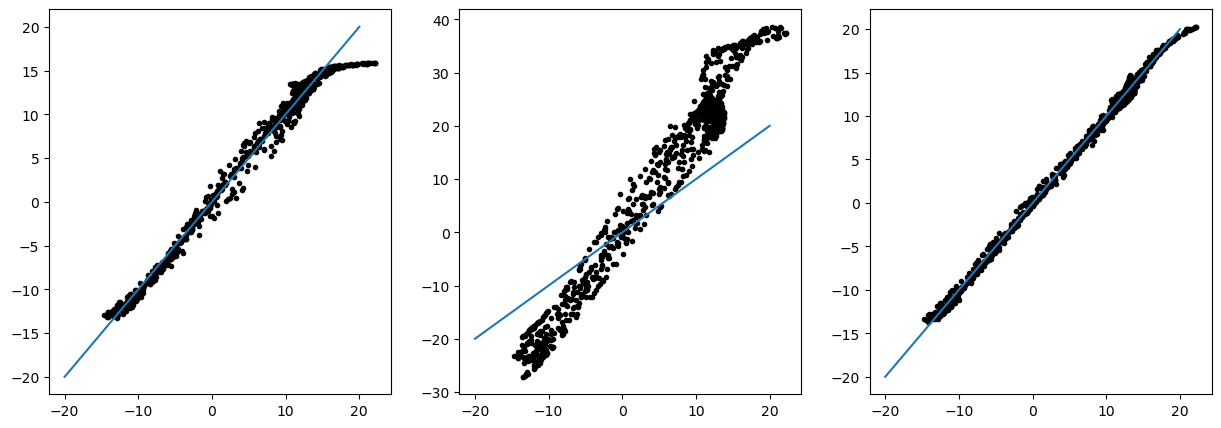

In [13]:
plt.figure(figsize=(15,5))
plt.subplot(1,3,1)
plt.scatter(Y, Y_ls0, s=9, c='k')
plt.plot([-20,20], [-20,20])
plt.subplot(1,3,2)
plt.scatter(Y, Y_ls, s=9, c='k')
plt.plot([-20,20], [-20,20])
plt.subplot(1,3,3)
plt.scatter(Y, Y_agg, s=9, c='k')
plt.plot([-20,20], [-20,20])
plt.savefig('boosting_nn_%.0f_yy_plot.eps' % (alpha*100,))
plt.show()

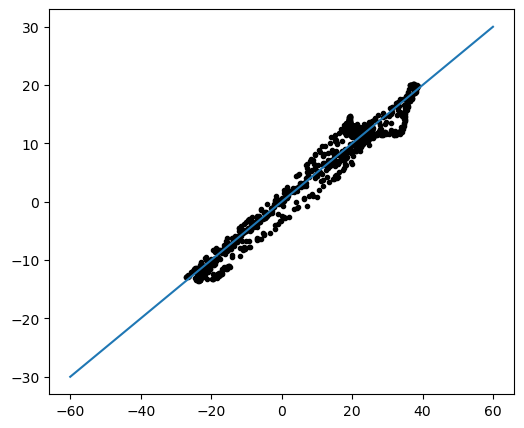

In [14]:
plt.figure(figsize=(6,5))
plt.scatter(Y_ls, Y_agg, s=9, c='k')
plt.plot([-60,60], [-30,30])
plt.show()

In [15]:
err_ls = np.abs(Y - Y_ls)
err_wm = np.abs(Y - Y_agg)

acc_ls = np.mean(err_ls)
acc_wm = np.mean(err_wm)
var_ls = np.mean(np.abs(err_ls - acc_ls))
var_wm = np.mean(np.abs(err_wm - acc_wm))

print(acc_ls, acc_wm)
print(var_ls, var_wm)

9.385481044794192 0.42591677173218423
4.004330453271399 0.26060529305189684


In [16]:
err_ls = np.abs(Y - Y_ls)
err_wm = np.abs(Y - Y_agg)
acc_ls = np.median(err_ls)
acc_wm = np.median(err_wm)
var_ls = np.median(np.abs(err_ls - acc_ls))
var_wm = np.median(np.abs(err_wm - acc_wm))

print(acc_ls, acc_wm)
print(var_ls, var_wm)

9.295087609821843 0.35481094231119314
3.216657586832885 0.2155390277053506


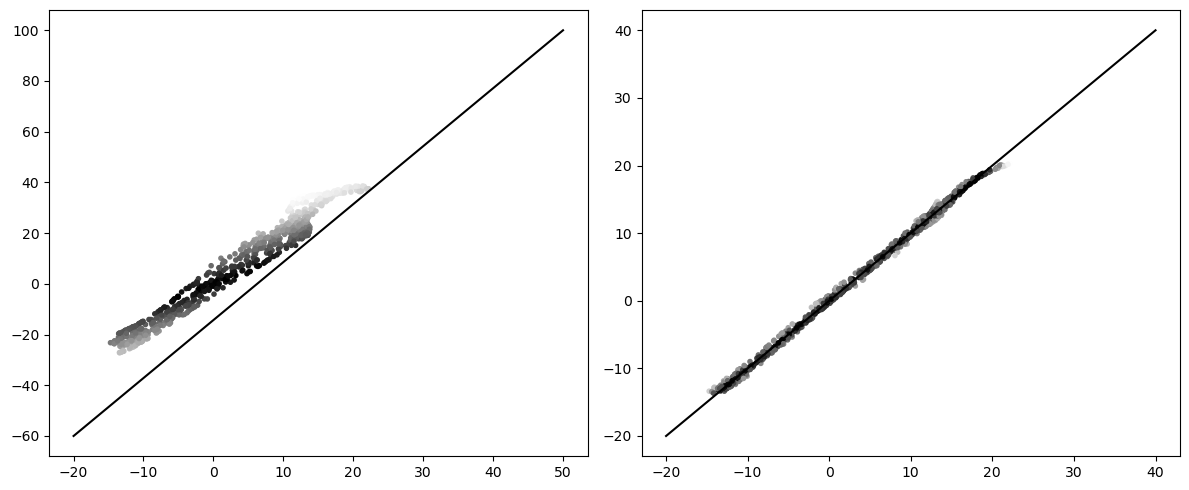

In [17]:
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.scatter(Y, Y_ls, c=np.abs(Y-Y_ls), s=9, cmap=plt.cm.Greys_r)
plt.plot([-20,50], [-60,100], color='k')
plt.subplot(1,2,2)
plt.scatter(Y, Y_agg, c=np.abs(Y-Y_agg), s=9, cmap=plt.cm.Greys_r)
plt.plot([-20,40], [-20,40], color='k')
plt.subplot(1,2,2)
plt.tight_layout()
plt.show()